In [1]:
# ## 1. 导入必要的库

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# %% [markdown]

In [5]:
# ## 2. 数据加载与探索

# %%
# 加载数据集
df = pd.read_csv('household_power_consumption.txt', sep=";")
df.head(10)

# %%
# 查看数据集信息
df.info()

# %% [markdown]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


C:\Users\MK\AppData\Local\Temp\ipykernel_19500\1222632647.py:5: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=";")


In [6]:
# ## 3. 数据预处理

# %%
# 创建datetime列并删除原始日期时间列
df['datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])
df.drop(['Date', 'Time'], axis=1, inplace=True)

# 处理缺失值
df.dropna(inplace=True)

# 查看数据时间范围
print("开始日期:", df['datetime'].min())
print("结束日期:", df['datetime'].max())

# %% [markdown]

C:\Users\MK\AppData\Local\Temp\ipykernel_19500\779221172.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])


开始日期: 2006-12-16 17:24:00
结束日期: 2010-11-26 21:02:00


In [ ]:
# ## 4. 数据集划分

# %%
# 按时间划分训练集和测试集
train = df.loc[df['datetime'] <= '2007-12-31']
test = df.loc[df['datetime'] > '2009-12-31']

print(f"训练集大小: {len(train)}")
print(f"测试集大小: {len(test)}")

# %% [markdown]

训练集大小: 542222
测试集大小: 458833


In [8]:
# ## 5. 数据归一化

# %%
# 初始化归一化器
feature_cols = [col for col in train.columns if col != 'datetime']
scaler = MinMaxScaler()

# 对训练集进行拟合和转换
train[feature_cols] = scaler.fit_transform(train[feature_cols])

# 对测试集进行转换（使用训练集的参数）
test[feature_cols] = scaler.transform(test[feature_cols])

# %% [markdown]

C:\Users\MK\AppData\Local\Temp\ipykernel_19500\3743982513.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[feature_cols] = scaler.fit_transform(train[feature_cols])
C:\Users\MK\AppData\Local\Temp\ipykernel_19500\3743982513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[feature_cols] = scaler.transform(test[feature_cols])


In [9]:
# ## 6. 创建时间序列数据

# %%
# 设置目标列
target_col = 'Global_active_power'

# 转换为NumPy数组
X_train = train[feature_cols].values
y_train = train[target_col].values
X_test = test[feature_cols].values
y_test = test[target_col].values

# %%
# 创建时间序列函数
def create_sequences(X, y, seq_length=24):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(xs), np.array(ys)

# 创建序列数据
seq_length = 24
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

print(f"训练序列形状: {X_train_seq.shape}")
print(f"测试序列形状: {X_test_seq.shape}")

# %% [markdown]

训练序列形状: (542198, 24, 7)
测试序列形状: (458809, 24, 7)


In [10]:
# ## 7. 创建PyTorch数据加载器

# %%
# 设置批量大小
batch_size = 64

# 创建Tensor数据集
train_dataset = TensorDataset(
    torch.tensor(X_train_seq, dtype=torch.float32), 
    torch.tensor(y_train_seq, dtype=torch.float32)
)

test_dataset = TensorDataset(
    torch.tensor(X_test_seq, dtype=torch.float32), 
    torch.tensor(y_test_seq, dtype=torch.float32)
)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# %% [markdown]

In [11]:
# ## 8. 构建LSTM模型

# %%
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM层输出
        out = out[:, -1, :]    # 取最后一个时间步
        out = self.fc(out)     # 全连接层
        return out.squeeze()   # 压缩输出维度

# 初始化模型
input_size = X_train_seq.shape[2]
model = LSTMModel(input_size)
print(model)

# %% [markdown]

LSTMModel(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


使用设备: cpu
Epoch 1/5, Loss: 0.000703
Epoch 2/5, Loss: 0.000669
Epoch 3/5, Loss: 0.000631
Epoch 4/5, Loss: 0.000604
Epoch 5/5, Loss: 0.000587


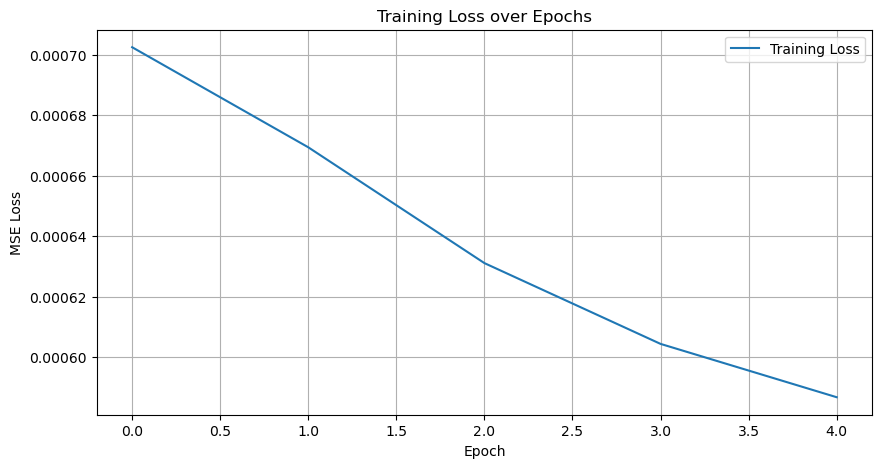

In [14]:
# ## 9. 模型训练

# %%
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
model = model.to(device)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 5
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 记录并打印损失
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

# %%
# 绘制训练损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]

In [15]:
# ## 10. 模型评估

# %%
# 在测试集上评估模型
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.extend(pred)
        actuals.extend(yb.numpy())

# 计算MSE
mse = mean_squared_error(actuals, preds)
print(f"测试集MSE: {mse:.6f}")

# 计算RMSE
rmse = np.sqrt(mse)
print(f"测试集RMSE: {rmse:.6f}")

# %% [markdown]

测试集MSE: 0.000404
测试集RMSE: 0.020111


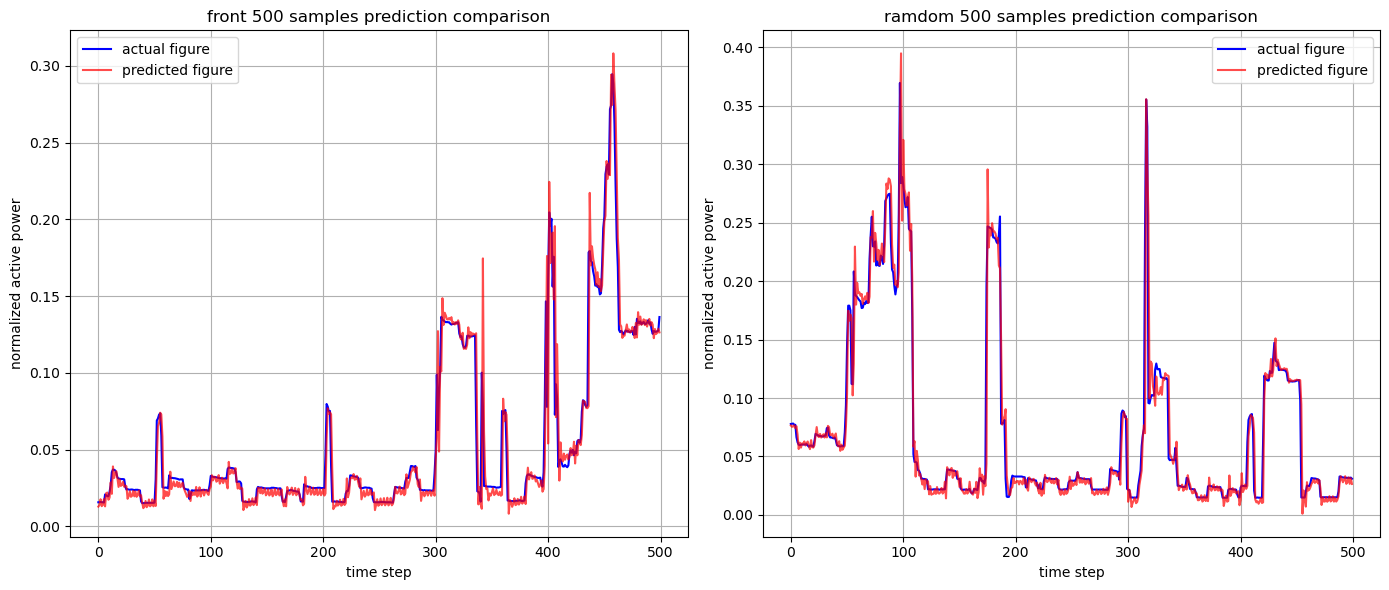

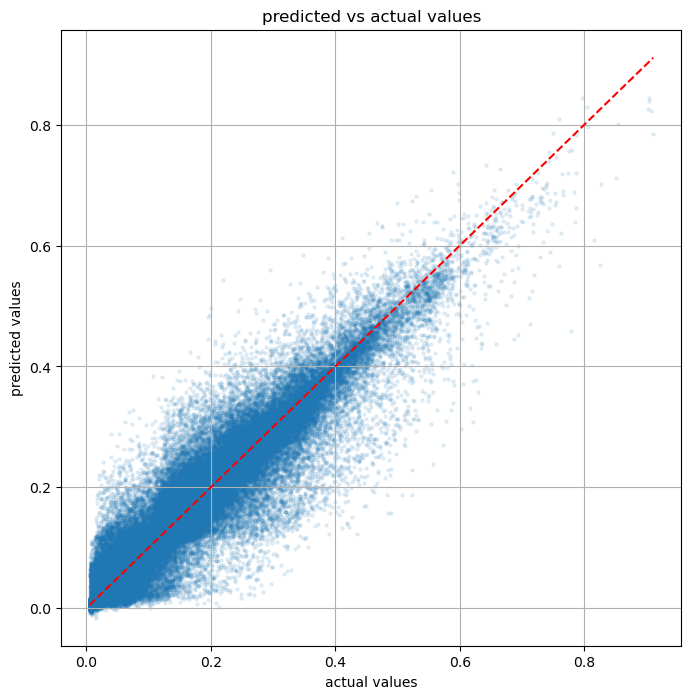

In [23]:
# ## 11. 结果可视化

# %%
# 绘制预测结果对比图
plt.figure(figsize=(14, 6))

# 前500个样本的对比
plt.subplot(1, 2, 1)
plt.plot(actuals[:500], 'b-', label='actual figure')
plt.plot(preds[:500], 'r-', alpha=0.7, label='predicted figure')
plt.title('front 500 samples prediction comparison')
plt.xlabel('time step')
plt.ylabel('normalized active power')
plt.legend()
plt.grid(True)

# 随机选择500个样本的对比
plt.subplot(1, 2, 2)
start_idx = np.random.randint(0, len(actuals)-500)
plt.plot(actuals[start_idx:start_idx+500], 'b-', label='actual figure')
plt.plot(preds[start_idx:start_idx+500], 'r-', alpha=0.7, label='predicted figure')
plt.title('ramdom 500 samples prediction comparison')
plt.xlabel('time step')
plt.ylabel('normalized active power')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# %%
# 绘制散点图展示预测值与实际值的关系
plt.figure(figsize=(8, 8))
plt.scatter(actuals, preds, alpha=0.1, s=5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.title('predicted vs actual values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.grid(True)
plt.show()

# %% [markdown]